# **SETUP**

In [ ]:
import os
import sys

sys.path.append("/home/ma012/AlexServer/phase2/src")
sys.path.append("/home/ma012/AlexServer/phase2/src/utils")

import random

import torch
import torch.nn.functional as F

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

from lime import lime_image

import shap

from model_utils import load_vit_model_config, load_cnn_model_config, set_seeds
from data_loader import create_dataloaders

from going_modular.going_modular.engine import  test_step, load_model_checkpoint
from helper_functions import plot_loss_curves,unnormalize, nhwc_to_nchw, nchw_to_nhwc, inv_transform


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [4]:
torch.__version__

'2.6.0+cu124'

In [ ]:
NUM_CLASSES = 3
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Prepare data
SEED = 42
NUM_WORKERS = 0 # os.cpu_count() 

DATASET_DIR = "/home/ma012/AlexServer/Dataset"

BATCH_SIZE_8 = 8
BATCH_SIZE_16 = 16

TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

# DEFAULT_SIZE = (256, 256)
# DEFAULT_NORMALIZE = transforms.Normalize(mean=MEAN,std=STD)
# CROP_SIZE = 224

# x_idx = random.randint(0, 11)

In [ ]:
ViT_CHECKPOINT = [
    # Figshare Au/home/ma012/AlexServer/phase2/log/drive/Figshare Augmentation/L16_21K_case3.pthgmentation
    ["/home/ma012/AlexServer/phase2/log/drive/Figshare Augmentation/L16_21K_case3.pth", "timm.vit_large_patch16_224.augreg_in21k.PRETRAINED"],

    # BT-4C
    ["/home/ma012/AlexServer/phase2/log/drive/ BT-4C/L16_1K_case3.pth", "torchvision.ViT_L_16_Weights.IMAGENET1K_V1"], 

    # Hugging Face
    ["/home/ma012/AlexServer/phase2/log/drive/Hugging Face/L16_1K_case3.pth", "torchvision.ViT_L_16_Weights.IMAGENET1K_V1"], 
]

In [5]:
CNN_CHECKPOINT = [
    ["/home/ma012/AlexServer/log/cnn_best/torchvision_VGG16_Weights_IMAGENET1K_V1.pth", "torchvision.VGG16_Weights.IMAGENET1K_V1"],
 
    ["/home/ma012/AlexServer/log/cnn_best/torchvision_MobileNet_V2_Weights_IMAGENET1K_V1.pth", "torchvision.MobileNet_V2_Weights.IMAGENET1K_V2"], 

    ["/home/ma012/AlexServer/log/cnn_best/torchvision_GoogLeNet_Weights_IMAGENET1K_V1.pth", "torchvision.GoogLeNet_Weights.IMAGENET1K_V1"], 
 
    ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Weights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],
    
    # ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Weights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],

    # ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Wevights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],

    # ["/home/ma012/AlexServer/log/cnn_best/torchvision_ResNet50_Weights_IMAGENET1K_V1.pth",  "torchvision.ResNet50_Weights.IMAGENET1K_V2" ],
]

# SHAP - General Configuration

In [7]:
TOPK = 3
# N_EVALS = 1000
N_EVALS = 100000

# Individual ViT - CNN 

In [ ]:
def getCustomTransforms(type:int) -> transforms.Compose:
    if(type == 1):
        model_config = "timm.vit_large_patch16_224.augreg_in21k.PRETRAINED"
        model_cp = "/home/ma012/AlexServer/phase2/log/drive/Figshare Augmentation/L16_21K_case3.pth"
    elif(type == 2):
        model_config = "torchvision.ViT_L_16_Weights.IMAGENET1K_V1"
        model_cp = "/home/ma012/AlexServer/phase2/log/drive/ BT-4C/L16_1K_case3.pth"
    elif(type == 3):
        model_config = "torchvision.ViT_L_16_Weights.IMAGENET1K_V1"
        model_cp = "/home/ma012/AlexServer/phase2/log/drive/Hugging Face/L16_1K_case3.pth"
    else:
        return False

    vit_model, vit_model_transforms = load_vit_model(model_config, NUM_CLASSES)
    load_vit_model = load_model_checkpoint(vit_model, model_cp, DEVICE)

    VIT_CUSTOM_TRANSFORMS = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        vit_model_transforms
    ])

    return VIT_CUSTOM_TRANSFORMS

PartitionExplainer explainer: 2it [00:22, 22.60s/it]               


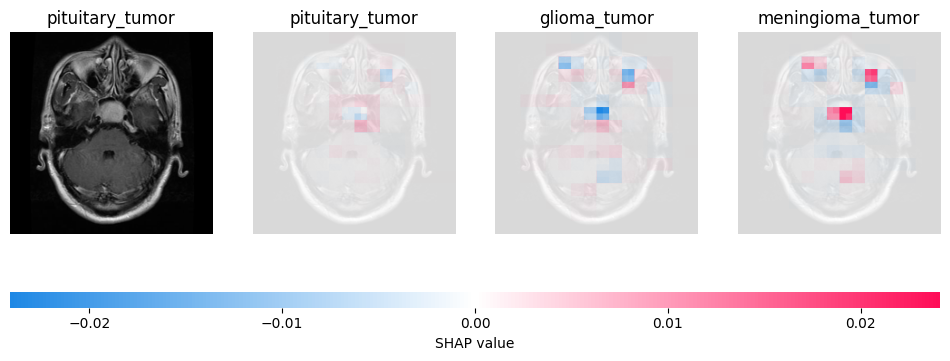

In [ ]:
MEAN_VIT=[0.5000, 0.5000, 0.5000]
STD_VIT=[0.5000, 0.5000, 0.5000]

vit_model, vit_model_transforms = load_vit_model_config(ViT_CHECKPOINT[0][], NUM_CLASSES)
load_vit_model = load_model_checkpoint(vit_model, "/home/ma012/AlexServer/log/vit_best/B16_21K_case3.pth", DEVICE)

VIT_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    vit_model_transforms
])


_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=VIT_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

transforms_img = transforms.Lambda(nchw_to_nhwc)
inv_transform_instance = inv_transform(MEAN_VIT,STD_VIT)

def predict(img: torch.Tensor):

    img = torch.Tensor(img) #nhwc

    img = nhwc_to_nchw(img)
    img = img.to(DEVICE)
    # print("xai model:",model)
    output = load_vit_model(img)

    return output

# for images, labels, paths in test_loader:

#     images_batch = images[0:2]  
#     labels_batch = labels[0:2]  
    
#     break  

# x = images[1:2] #nchw
# # convert to nhwc for shap requirements
# x = transforms_img(x) # (1,224,224,3)

# label = labels[1:2]
# print(f"{paths[1:2]}")

test_img_path= "/home/ma012/AlexServer/Dataset/pituitary_tumor/994.jpg"
img = Image.open(test_img_path)

x = VIT_CUSTOM_TRANSFORMS(img) #3,224,224
x_expanded = x.unsqueeze(0) #1,3,224,224

x_tr = transforms_img(x_expanded) #(1,224,224,3)

# # background_image = images[0]
background_image = x
background_image = background_image.permute(1,2,0)

topk = 3
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)",background_image.shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=CLASS_NAMES)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    x_tr,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform_instance(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[CLASS_NAMES[2]],
)

**2. CNN**

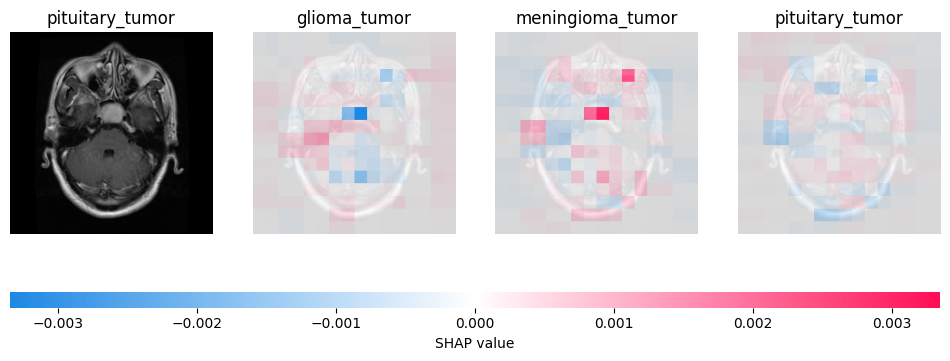

In [6]:
MEAN_CNN=[0.485, 0.456, 0.406]
STD_CNN=[0.229, 0.224, 0.225]

cnn_model, cnn_model_transforms = load_cnn_model("torchvision.MobileNet_V2_Weights.IMAGENET1K_V2", NUM_CLASSES)
cnn_model_load = load_model_checkpoint(cnn_model, "/home/ma012/AlexServer/log/cnn_best/torchvision_MobileNet_V2_Weights_IMAGENET1K_V1.pth", DEVICE)

CNN_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    cnn_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=CNN_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

transforms_img = transforms.Lambda(nchw_to_nhwc)
inv_transform_instance = inv_transform(MEAN_CNN,STD_CNN)

def predict(img: torch.Tensor):

    img = torch.Tensor(img) #nhwc

    img = nhwc_to_nchw(img)
    img = img.to(DEVICE)
    # print("xai model:",model)
    output = cnn_model_load(img)

    return output

for images, labels, paths in test_loader:

    images_batch = images[0:2]  
    labels_batch = labels[0:2]  
    
    break  

# x = images[1:2] #nchw
# x = transforms_img(x) # (1,224,224,3)

# label = labels[1:2]
# print(f"{paths[1:2]}")

test_img_path= "/home/ma012/AlexServer/Dataset/pituitary_tumor/994.jpg"
img = Image.open(test_img_path)

x = CNN_CUSTOM_TRANSFORMS(img) #3,224,224
x_expanded = x.unsqueeze(0) #1,3,224,224

x_tr = transforms_img(x_expanded) #(1,224,224,3)

# # background_image = images[0]
background_image = x
background_image = background_image.permute(1,2,0)


topk = 3
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)",background_image.shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=CLASS_NAMES)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    x_tr,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform_instance(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[CLASS_NAMES[2]],
)

In [ ]:
np.save("/home/ma012/AlexServer/log/XAI/correct/ViT_ensemble_pt1195.npy", shap_values)

## Plot histogram

In [ ]:
# Define color labels
colors = ['red', 'green', 'blue']

# Create a single row of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # (rows, columns)

# Loop over RGB channels
for i, color in enumerate(colors):
    # Extract the specific channel for all images and flatten
    pixels = shap_values_np[:, :, :, i].flatten()
    
    # Plot histogram in the corresponding subplot
    axes[i].hist(pixels, bins=256, color=color, alpha=0.7)
    axes[i].set_title(f'{color.upper()} Channel Histogram')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim([np.min(pixels), np.max(pixels)])  # Auto-scale x-axis

# Adjust layout for better spacing
plt.tight_layout()

# Show the row of histograms
plt.show()


# **LIME**

## ViT configuration

In [ ]:

MEAN_VIT=[0.5000, 0.5000, 0.5000]
STD_VIT=[0.5000, 0.5000, 0.5000]

vit_model, vit_model_transforms = load_vit_model("timm.vit_base_patch16_224.augreg_in21k.PRETRAINED", NUM_CLASSES)
load_vit_model = load_model_checkpoint(vit_model, "/home/ma012/AlexServer/log/vit_best/B16_21K_case3.pth", DEVICE)

VIT_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    vit_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=VIT_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

## CNN configuration

In [7]:
MEAN_CNN=[0.485, 0.456, 0.406]
STD_CNN=[0.229, 0.224, 0.225]

cnn_model, cnn_model_transforms = load_cnn_model("torchvision.MobileNet_V2_Weights.IMAGENET1K_V2", NUM_CLASSES)
cnn_model_load = load_model_checkpoint(cnn_model, "/home/ma012/AlexServer/log/cnn_best/torchvision_MobileNet_V2_Weights_IMAGENET1K_V1.pth", DEVICE)

CNN_CUSTOM_TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    cnn_model_transforms
])

_, _, test_loader = create_dataloaders(
    dataset_dir=DATASET_DIR,
    transform=CNN_CUSTOM_TRANSFORMS,
    batch_size=BATCH_SIZE_16,
    num_workers=NUM_WORKERS,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED
)

loss_fn = torch.nn.CrossEntropyLoss()

## LIME - General Configuration

In [8]:
# input transform for LIME
def get_pil_transform(type='vit'): 

    CROP_SIZE = 224

    if(type=='cnn'):
        RESIZE_SIZE = (256,256)
        print("cnn")
    else:
        RESIZE_SIZE = (248,248)

    transf = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(RESIZE_SIZE, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(CROP_SIZE)
    ])    

    return transf

# add convert to tensor for model
def get_preprocess_transform(type='vit'): 

    if(type == 'cnn'):
        mean = MEAN_CNN
        std = STD_CNN
        print("cnn")
    else:
        mean = MEAN_VIT
        std = STD_VIT

    normalize = transforms.Normalize(mean,std)
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

In [8]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

models_list = []
for cp_path, model_cfg in ViT_CHECKPOINT:
    model,model_transforms = load_vit_model(model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)
    
    models_list.append(model)

ViT original head


In [10]:
pill_transf = get_pil_transform('cnn')
preprocess_transform = get_preprocess_transform('cnn')

models_list = []
for cp_path, model_cfg in CNN_CHECKPOINT:
    model,model_transforms = load_cnn_model(DEVICE,model_cfg, NUM_CLASSES)
    model = load_model_checkpoint(model, cp_path, DEVICE)
    
    models_list.append(model)

cnn
cnn


### get image 

In [9]:
# Both of ViT & CNN Incorrect: "/home/ma012/AlexServer/Dataset/meningioma_tumor/33.jpg"
test_img_path="/home/ma012/AlexServer/Dataset/pituitary_tumor/994.jpg"
img = Image.open(test_img_path)

# image_unnormalize = inv_transform_instance(images[1])
# img_input = np.array(image_unnormalize) #hwc

### Single model LIME

1. ViT

100%|██████████| 1000/1000 [00:02<00:00, 390.91it/s]


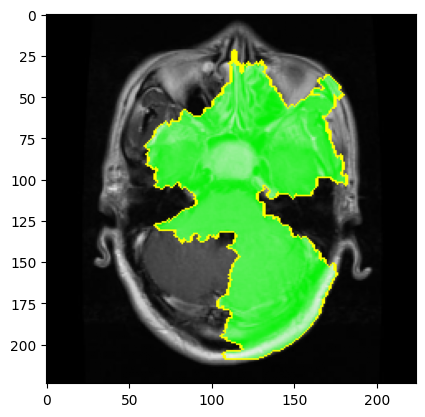

In [10]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def lime_predict(images):
 
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    batch = batch.to(DEVICE)

    logits = load_vit_model(batch)
    probs = F.softmax(logits,dim = 1)

    return probs.detach().cpu().numpy()

#input image: hwc

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         lime_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # size of the neighborhood to learn the linear model
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)

plt.imshow(img_boundry)

**2. CNN**

cnn
cnn


100%|██████████| 1000/1000 [00:01<00:00, 827.79it/s]


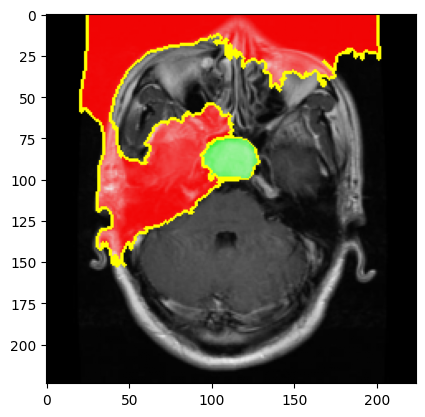

In [11]:
pill_transf = get_pil_transform('cnn')
preprocess_transform = get_preprocess_transform('cnn')

def lime_predict(images):
 
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    batch = batch.to(DEVICE)

    logits = cnn_model_load(batch)
    probs = F.softmax(logits,dim = 1)

    return probs.detach().cpu().numpy()

#input image: hwc

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         lime_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # size of the neighborhood to learn the linear model
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

plt.imshow(img_boundry1)
